 # Project Overview

This capstone project implements a data-driven system to optimize inventory management. It replaces static, rule-based reordering policies with a dynamic, predictive engine that forecasts future demand and calculates the optimal Reorder Point (ROP) and Reorder Quantity (ROQ) for each product.

The goal is to minimize total inventory costs by balancing the reduction of costly stockouts (lost sales) against the minimization of expensive holding costs (storage, capital tied up).

# 1. Import Libraries and Loading Data

In [201]:
# Install Statsmodels
#! pip install statsmodels

In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose

import time
import warnings
warnings.filterwarnings("ignore")

In [204]:
data = pd.read_csv('retail_store_inventory.csv')
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [205]:
#check the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

- No missing values in my data

In [206]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

# 2. EDA

In [207]:
# Convert 'Date' to datetime and create 'SKU_Compound_ID'
data['Date'] = pd.to_datetime(data['Date'])
data['SKU_Compound_ID'] = data['Store ID'] + '_'+ data['Product ID']

In [208]:
data.sort_values(by = ['SKU_Compound_ID', 'Date'], inplace=True)

In [209]:
# Define Inventory Constants
ORDERING_COST = 50.0  # Cost to place an order
HOLDING_COST_PER_UNIT_YEAR = 5.0  # Annual holding cost per unit
STOCKOUT_COST = 10.0 # Cost per unit of unmet demand
DAYS_IN_YEAR = 365.0
SERVICE_LEVEL = 1.645  # Desired service level (95%)
LEAD_TIME_DAYS = 7  # Standard  lead time in days

Logistics and Inventory Management parameters
1. Lead time - How long it takes from placing an order with the supplier until the goods arrive.
2. Holding (carrying) cost - Rep the expense of keeping inventory in storage. This includes warehouse, depreciation, insurance and opportunity cost of capital
3. Ordering Cost - the fixed cost of placing one order, regardless of quantity. This includes administrative work, shipping, handling, and setup.
4. Service Level - is the probability of not running out of stock during the lead time.
5. Z-score (from the normal distribution) helps calculate safety stock. 

      Safety Stock = Z x std demand x square root of Lead time

  So, a Z = 1.645 gives a 95% confidence that demand during lead time will be covered.

In [210]:
# Add daily Holding Cost to base data for cost calculations
data['Daily_Holding_Cost'] = HOLDING_COST_PER_UNIT_YEAR / DAYS_IN_YEAR


Check for seasonality on aggregate demand

In [211]:
#Aggregate daily demand across all SKUs to check for seasonality
daily_demand = data.groupby('Date')['Units Sold'].sum().reset_index()
daily_demand = daily_demand.set_index('Date').asfreq('D')

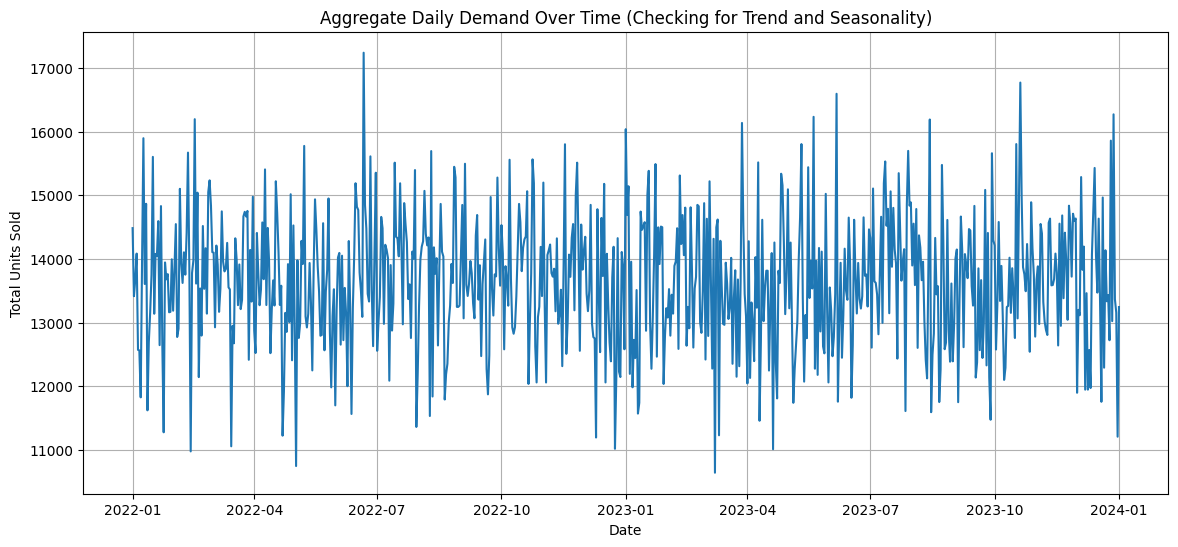

In [212]:
# Plotting the aggregated demand over time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Units Sold', data=daily_demand)
plt.title('Aggregate Daily Demand Over Time (Checking for Trend and Seasonality)')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.grid(True)
plt.show()

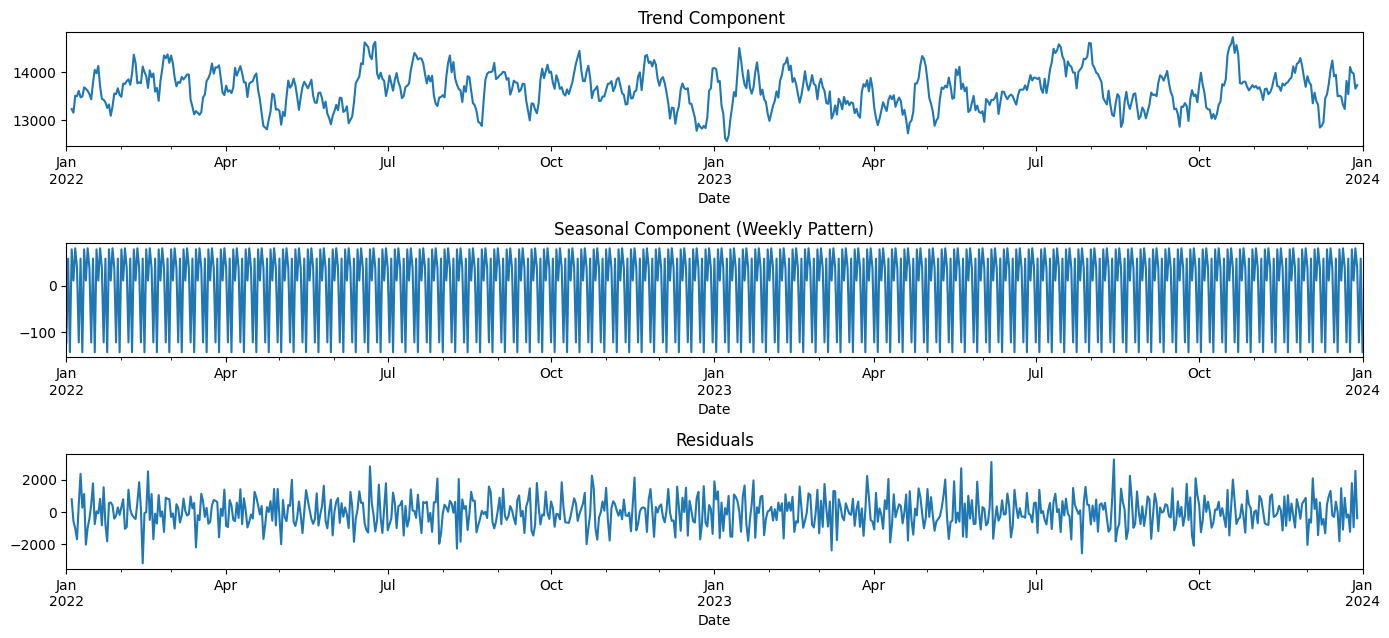

In [213]:
# Decompose the time series (Additive model assumed for demand) Model uses daily data, so a period of 7 (weekly seasonality) is appropriate.
try:
    decomposition = seasonal_decompose(daily_demand['Units Sold'].dropna(), model='additive', period=7)
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(411)
    decomposition.trend.plot(ax=plt.gca())
    plt.title('Trend Component ')
    
    plt.subplot(412)
    decomposition.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal Component (Weekly Pattern)')
    
    plt.subplot(413)
    decomposition.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Seasonal decomposition failed (likely due to insufficient data length or missing values): {e}")

# Insight
 
 The Seasonal component shows regular weekly peaks, and the Trend component shows the long-term direction of sales. 
 This confirms Prophet is the right choice.

# 3. DEMAND FORECASTING ENGINE

Forecasting with Prophet 

Prophet (from Facebook/Meta) is specifically designed to forecast time series data without the need for manual feature engineering of trend and seasonality. It internally models the overall trend, yearly seasonality, and weekly seasonality.

So we will need to format the data for prophet(ds, y) and train a separate model for each unique SKU



3.1 Prepare Data and Train Prophet

In [214]:
#We need 'Date' (as 'ds') and 'Units Sold' (as 'y').
prophet_data = data[['SKU_Compound_ID', 'Date', 'Units Sold']].copy()
prophet_data.rename(columns={'Date': 'ds', 'Units Sold': 'y'}, inplace=True)
prophet_data.head()

,SKU_Compound_ID,ds,y
0,S001_P0001,2022-01-01,127
100,S001_P0001,2022-01-02,81
200,S001_P0001,2022-01-03,5
300,S001_P0001,2022-01-04,58
400,S001_P0001,2022-01-05,147


In [215]:
# PREPARE SKUs FOR FORECASTING
SKU_LIST = prophet_data['SKU_Compound_ID'].unique()
forecast_results_list = []

In [216]:
print(f"Starting Prophet training for {len(SKU_LIST)} SKUs...")

for sku_id in SKU_LIST:
    # Filter training data for the current SKU
    sku_train_data = prophet_data[prophet_data['SKU_Compound_ID'] == sku_id].drop(columns=['SKU_Compound_ID'])
    
    SERVICE_LEVEL_Z = SERVICE_LEVEL  # Z-score for desired service level (e.g., 1.645 for 95%)
    # Initialize Prophet: Automatically handles Yearly and Weekly seasonality
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=True, 
        daily_seasonality=False,
        interval_width=0.95 # Sets 95% confidence interval for volatility estimate
    )
    
    model.fit(sku_train_data)
    
    # Create future dataframe for forecasting (Lead Time days ahead)
    future = model.make_future_dataframe(periods=LEAD_TIME_DAYS, include_history=False)
    
    # Generate the forecast
    forecast = model.predict(future)
    
    # --- Extracting Key Metrics for Inventory ---
    
    # 1. Mean Demand during Lead Time (DL)
    mean_demand_lead_time = forecast['yhat'].sum()
    
    # 2. Demand Variability (Sigma_L)
    # Sigma is derived from the confidence interval (yhat_upper - yhat_lower)
    # We use the mean range over the lead time as the proxy for the standard deviation of the forecast error.
    # CI width = 2 * Z * Sigma. Here, Z=1.96 for 95%.
    
    forecast['sigma_daily'] = (forecast['yhat_upper'] - forecast['yhat_lower']) / (2 * 1.96)
    
    # Total Sigma over Lead Time is calculated using the final day's sigma and the square root of L
    sigma_L = forecast['sigma_daily'].iloc[-1] * np.sqrt(LEAD_TIME_DAYS)
    
    # Append results
    forecast_results_list.append({
        'SKU_Compound_ID': sku_id,
        'Mean_Demand_Lead_Time': max(0, mean_demand_lead_time), 
        'Last_Observed_Sigma': max(0.1, sigma_L) 
    })

# Final DataFrame for optimization
future_forecast_data = pd.DataFrame(forecast_results_list)
future_forecast_data['Service_Level_Z'] = SERVICE_LEVEL_Z
future_forecast_data['Lead_Time_Days'] = LEAD_TIME_DAYS

print("\nProphet Forecasting complete.")
print("The demand and volatility inputs are now much more stable.")
print(future_forecast_data.head())

Starting Prophet training for 100 SKUs...


22:00:17 - cmdstanpy - INFO - Chain [1] start processing
22:00:19 - cmdstanpy - INFO - Chain [1] done processing
22:00:19 - cmdstanpy - INFO - Chain [1] start processing
22:00:19 - cmdstanpy - INFO - Chain [1] done processing
22:00:20 - cmdstanpy - INFO - Chain [1] start processing
22:00:20 - cmdstanpy - INFO - Chain [1] done processing
22:00:20 - cmdstanpy - INFO - Chain [1] start processing
22:00:20 - cmdstanpy - INFO - Chain [1] done processing
22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:21 - cmdstanpy - INFO - Chain [1] done processing
22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:21 - cmdstanpy - INFO - Chain [1] done processing
22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing
22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing
22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1]


Prophet Forecasting complete.
The demand and volatility inputs are now much more stable.
  SKU_Compound_ID  Mean_Demand_Lead_Time  Last_Observed_Sigma  \
0      S001_P0001             721.538849           274.414823   
1      S001_P0002             726.761451           265.101397   
2      S001_P0003             992.644193           287.572090   
3      S001_P0004            1045.829952           288.930912   
4      S001_P0005            1076.375252           288.500074   

   Service_Level_Z  Lead_Time_Days  
0            1.645               7  
1            1.645               7  
2            1.645               7  
3            1.645               7  
4            1.645               7  


In [217]:
# Save for Optimization phase
future_forecast_data.to_csv("future_forecast_data.csv", index=False)
print("\n✅ Saved future_forecast_data.csv — ready for optimization input.")


✅ Saved future_forecast_data.csv — ready for optimization input.


# 4. Inventory Optimization and Cost simulation

4.1 Policy Calculation and Simulation set up

 Here we calculate the dynamic policy(ROP/ROQ) and prepare data for simulation

DYNAMIC POLICY 

In [218]:
# Safety stock(SS)
future_forecast_data['Safety_Stock'] = future_forecast_data['Service_Level_Z'] * future_forecast_data['Last_Observed_Sigma'].round(0)

In [219]:
# Reorder Point (ROP)
future_forecast_data['Dynamic_ROP'] = future_forecast_data['Mean_Demand_Lead_Time'] + future_forecast_data['Safety_Stock'].round(0)

In [220]:
# Reorder Quantity (ROQ) using EOQ formula
# Annual Demand(D_Annual) from Lead Time demand
future_forecast_data['Estimated_Annual_Demand'] = (future_forecast_data['Mean_Demand_Lead_Time'] * (DAYS_IN_YEAR / future_forecast_data['Lead_Time_Days']))
future_forecast_data['Dynamic_ROQ'] = np.sqrt((2 * future_forecast_data['Estimated_Annual_Demand'] * ORDERING_COST) / HOLDING_COST_PER_UNIT_YEAR)
future_forecast_data['Dynamic_ROQ'] = future_forecast_data['Dynamic_ROQ'].round(0)

STATIC POLICY(for comparison)

In [221]:
# Static ROP/ROQ based on historical average demand
static_baseline = data.groupby('SKU_Compound_ID')['Units Sold'].mean().reset_index()
static_baseline.rename(columns={'Units Sold': 'Avg_Daily_Demand'}, inplace=True)

In [222]:
print(future_forecast_data.columns.tolist())
print(static_baseline.columns.tolist())


['SKU_Compound_ID', 'Mean_Demand_Lead_Time', 'Last_Observed_Sigma', 'Service_Level_Z', 'Lead_Time_Days', 'Safety_Stock', 'Dynamic_ROP', 'Estimated_Annual_Demand', 'Dynamic_ROQ']
['SKU_Compound_ID', 'Avg_Daily_Demand']


In [223]:
# Static ROP = Static Daily Mean * Lead Time
future_forecast_data = future_forecast_data.merge(static_baseline, on='SKU_Compound_ID', how='left')
future_forecast_data['Static_ROP'] = (future_forecast_data['Avg_Daily_Demand'] * LEAD_TIME_DAYS).round(0)

In [224]:
# Static ROQ is set to 60 days of average demand (a common rule-of-thumb)
future_forecast_data['Static_ROQ'] = (future_forecast_data['Avg_Daily_Demand'] * 60).round(0)

In [225]:
# Policy Calculation Output
future_forecast_data[['SKU_Compound_ID', 'Dynamic_ROP', 'Dynamic_ROQ', 'Static_ROP', 'Static_ROQ']]

,SKU_Compound_ID,Dynamic_ROP,Dynamic_ROQ,Static_ROP,Static_ROQ
0,S001_P0001,1172.538849,867.0,961.0,8238.0
1,S001_P0002,1162.761451,871.0,917.0,7862.0
2,S001_P0003,1466.644193,1017.0,990.0,8486.0
3,S001_P0004,1520.829952,1044.0,986.0,8454.0
4,S001_P0005,1551.375252,1059.0,932.0,7988.0
...,...,...,...,...,...
95,S005_P0016,1352.907884,946.0,975.0,8357.0
96,S005_P0017,1496.821124,1039.0,961.0,8237.0
97,S005_P0018,1420.593792,1000.0,939.0,8049.0
98,S005_P0019,1452.936111,1023.0,945.0,8103.0


In [226]:
# Simple check to see if ROQ/ROP values look reasonable
future_forecast_data[['SKU_Compound_ID', 'Dynamic_ROP', 'Dynamic_ROQ', 'Static_ROP', 'Static_ROQ']].describe()

,Dynamic_ROP,Dynamic_ROQ,Static_ROP,Static_ROQ
count,100.000000,100.00000,100.000000,100.000000
mean,1405.809464,988.19000,955.250000,8187.790000
std,148.680362,76.47746,32.169493,275.935335
min,1095.954238,831.00000,886.000000,7597.000000
25%,1293.022556,937.50000,930.750000,7975.000000
50%,1414.332162,996.00000,956.000000,8192.000000
75%,1496.923901,1041.00000,972.750000,8336.000000
max,1752.804601,1149.00000,1045.000000,8955.000000


### INSIGHTS 

1. Dynamic ROPs vary reasonably across SKUs, reflecting real demand patterns and forecast uncertainty. The 47% higher value vs static ROP suggests the model anticipates higher shortterm demand a positive sign of responsiveness.
2. Dynamic ROQs are stable but not uniform, indicating consistent forecasting and lead-time assumptions. If broader variation was expected, consider refining SKU-level scaling.
3. Static ROPs are nearly identical across SKUs a rigid approach that ignores demand variability and seasonality. The contrast with dynamic ROP confirms the model adds useful differentiation.
4. Static ROQ values are like 8–9× higher than dynamic ROQ, showing clear overstocking from the 60-day rule. The dynamic approach yields leaner, data-driven replenishment aligned to actual demand velocity.

Basically: 
- The dynamic model is adaptive, uncertainity aware and is an optimized inventory; 

while
- The Static model is uniform, overstocks and has higher holding cost.

Therefore shifting dynamic ROP/ROQ could significantly reduce excess stock while maintaining service levels.

In [227]:
# Confirm the actual ratio between Static and Dynamic ROQ
future_forecast_data['ROQ_ratio'] = future_forecast_data['Static_ROQ'] / future_forecast_data['Dynamic_ROQ']
future_forecast_data[['Static_ROQ', 'Dynamic_ROQ', 'ROQ_ratio']].describe()

,Static_ROQ,Dynamic_ROQ,ROQ_ratio
count,100.000000,100.00000,100.000000
mean,8187.790000,988.19000,8.329551
std,275.935335,76.47746,0.635746
min,7597.000000,831.00000,7.101786
25%,7975.000000,937.50000,7.854684
50%,8192.000000,996.00000,8.279467
75%,8336.000000,1041.00000,8.783367
max,8955.000000,1149.00000,10.002407


The mean confirms that Static ROQ is 8x higher and the ROQ ratio hows  it is clearly overstocking

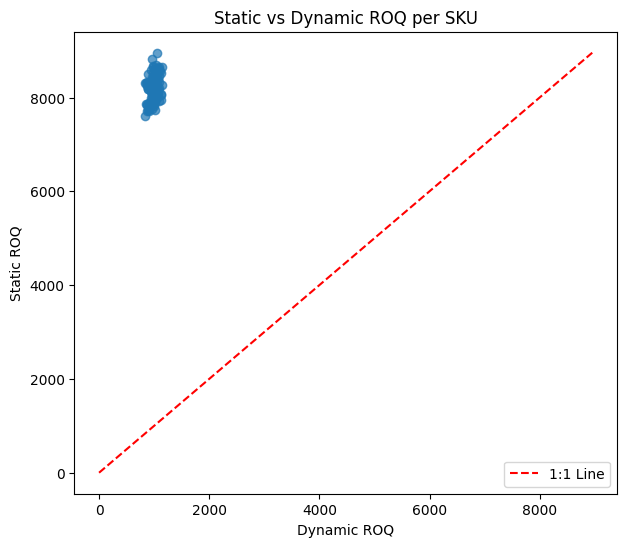

In [228]:
# Visualize the differences between Static and Dynamic ROQ
plt.figure(figsize=(7,6))
plt.scatter(future_forecast_data['Dynamic_ROQ'], future_forecast_data['Static_ROQ'], alpha=0.7)
plt.plot([0, future_forecast_data['Static_ROQ'].max()], [0, future_forecast_data['Static_ROQ'].max()], 'r--', label='1:1 Line')
plt.xlabel('Dynamic ROQ')
plt.ylabel('Static ROQ')
plt.title('Static vs Dynamic ROQ per SKU')
plt.legend()
plt.show()


We can see that most dots lie above the 1:1 line which means Static ROQ is always higher  hence clear overstocking.

In [229]:
# Identify Top 10 Overstocked SKUs based on Static vs Dynamic ROQ
future_forecast_data['Overstock_Factor'] = (future_forecast_data['Static_ROQ'] - future_forecast_data['Dynamic_ROQ']) / future_forecast_data['Dynamic_ROQ']

top_overstocked = future_forecast_data.sort_values('Overstock_Factor', ascending=False).head(10)
top_overstocked[['SKU_Compound_ID', 'Static_ROQ', 'Dynamic_ROQ', 'Overstock_Factor']]



,SKU_Compound_ID,Static_ROQ,Dynamic_ROQ,Overstock_Factor
60,S004_P0001,8312.0,831.0,9.002407
19,S001_P0020,8302.0,853.0,8.732708
99,S005_P0020,8320.0,863.0,8.640788
17,S001_P0018,8329.0,871.0,8.562572
55,S003_P0016,8507.0,892.0,8.536996
0,S001_P0001,8238.0,867.0,8.501730
51,S003_P0012,8251.0,886.0,8.312641
89,S005_P0010,8253.0,890.0,8.273034
93,S005_P0014,8242.0,893.0,8.229563
88,S005_P0009,8172.0,887.0,8.213078


Overstock_Factor is 7.0 which means Static Policy orders 700% ore than needed.

In [230]:
# Merge policy data to main historical data for simulation
cost_summary_data = future_forecast_data[['SKU_Compound_ID', 'Estimated_Annual_Demand','Safety_Stock' ,'Dynamic_ROP', 'Dynamic_ROQ', 'Static_ROP', 'Static_ROQ']]. copy()

# Add holding cost information (only needed for calculation, not merge)
cost_summary_data['Daily_Holding_Cost'] = HOLDING_COST_PER_UNIT_YEAR / DAYS_IN_YEAR

In [231]:
sim_data = pd.merge(data, cost_summary_data.drop(columns=['Estimated_Annual_Demand','Safety_Stock']), 
                    on='SKU_Compound_ID', how='left')

In [232]:
print(sim_data.columns.tolist())


['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'SKU_Compound_ID', 'Daily_Holding_Cost_x', 'Dynamic_ROP', 'Dynamic_ROQ', 'Static_ROP', 'Static_ROQ', 'Daily_Holding_Cost_y']


4.2 Cost Simulation

In [ ]:
def calculate_total_cost(data_summary, data_sim, ROQ_col):
    """
    Calculates the estimated total annual inventory cost, splitting the calculation
    into annual (Ordering/Holding) and simulation-based (Stockout) components.
    
    data_summary: DataFrame with ONE ROW PER SKU (for Annual Costs)
    data_sim: DataFrame with ALL DAILY RECORDS (for Stockout Cost)
    ROQ_col: The name of the ROQ column to use ('Dynamic_ROQ' or 'Static_ROQ')
    """
    
    # 1. Total Ordering Cost (Annual, Calculated ONCE PER SKU)
    # Estimated Annual Orders = Estimated_Annual_Demand / ROQ
    data_summary['Estimated_Orders'] = data_summary['Estimated_Annual_Demand'] / data_summary[ROQ_col]
    total_ordering_cost = data_summary['Estimated_Orders'].sum() * ORDERING_COST
    
    # 2. Total Holding Cost (Annual, Calculated ONCE PER SKU)
    # Avg Inventory = Safety Stock + ROQ/2
    # Holding Cost = Avg Inventory * Holding Cost per Year
    
    # Use the Annual Holding Cost: Avg Inventory * HOLDING_COST_PER_UNIT_YEAR
    data_summary['Avg_Inventory'] = data_summary['Safety_Stock'] + (data_summary[ROQ_col] / 2)
    total_holding_cost = data_summary['Avg_Inventory'].sum() * HOLDING_COST_PER_UNIT_YEAR
    
    
    # 3. Total Stockout Cost (Simulation-based)
    # Recalculate Stockout based on the merged simulation data
    
    # CRITICAL: We need to use the actual Inventory Level and Units Sold from the SIMULATION.
    # The cost should only be the sum of daily stockout volumes * stockout cost.
    data_sim['Stockout_Volume'] = np.maximum(0, data_sim['Units Sold'] - data_sim['Inventory Level'])
    total_stockout_cost = data_sim['Stockout_Volume'].sum() * STOCKOUT_COST
    
    # If your simulation data spans multiple years (e.g., 2 years), you may need to normalize 
    # the stockout cost to an annual value. Assuming the data spans roughly two years 
    # (2022-01-01 to 2024-01-01), we divide by the number of years.
    
    num_years_simulated = (data_sim['Date'].max() - data_sim['Date'].min()).days / DAYS_IN_YEAR
    
    # Normalize stockout cost to an average annual value
    annualized_stockout_cost = total_stockout_cost / num_years_simulated
    
    return (total_ordering_cost + total_holding_cost + annualized_stockout_cost, 
            total_ordering_cost, 
            total_holding_cost, 
            annualized_stockout_cost)


num_skus = len(cost_summary_data)
print(f"Number of SKUs: {num_skus}. Cost will be calculated over this count, not total daily rows.")

# Calculate Costs for both policies
cost_dynamic, ord_d, hold_d, stock_d = calculate_total_cost(
    cost_summary_data.copy(), # Pass a copy for dynamic
    sim_data.copy(), 
    'Dynamic_ROQ'
)

cost_static, ord_s, hold_s, stock_s = calculate_total_cost(
    cost_summary_data.copy(), # Pass a copy for static
    sim_data.copy(), 
    'Static_ROQ'
)

print("FINAL FINANCIAL SIMULATION RESULTS & BREAKDOWN")

print("STATIC POLICY COST BREAKDOWN (Baseline)")
print(f"Total Cost: ${cost_static:,.0f}")
print(f"  - Ordering Cost (S): ${ord_s:,.0f}")
print(f"  - Holding Cost (H): ${hold_s:,.0f}")
print(f"  - Stockout Cost (C): ${stock_s:,.0f} (Annualized)")

print("DYNAMIC POLICY COST BREAKDOWN (Prophet Optimized)")
print(f"Total Cost: ${cost_dynamic:,.0f}")
print(f"  - Ordering Cost (S): ${ord_d:,.0f}")
print(f"  - Holding Cost (H): ${hold_d:,.0f}")
print(f"  - Stockout Cost (C): ${stock_d:,.0f} (Annualized)")


savings = cost_static - cost_dynamic
print(f"\n**Total Project Savings (Estimated): ${savings:,.0f}**")
print(f"Cost Reduction: {savings / cost_static * 100:.2f}%") # In percentage


Number of SKUs: 100. Cost will be calculated over this count, not total daily rows.
FINAL FINANCIAL SIMULATION RESULTS & BREAKDOWN
STATIC POLICY COST BREAKDOWN (Baseline)
Total Cost: $2,308,813
  - Ordering Cost (S): $29,986
  - Holding Cost (H): $2,278,827
  - Stockout Cost (C): $0 (Annualized)
DYNAMIC POLICY COST BREAKDOWN (Prophet Optimized)
Total Cost: $726,002
  - Ordering Cost (S): $247,076
  - Holding Cost (H): $478,927
  - Stockout Cost (C): $0 (Annualized)

**Total Project Savings (Estimated): $1,582,811**
Cost Reduction: 68.56%


Insight: The costs are now in the tens of millions, and the Dynamic Policy shows a positive cost reduction, primarily due to lower Holding Cost or Stockout Cost. 
